In [1]:
import torch as tc
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import pandas as pd
import numpy as np

from functions import LMF, MF, NMF, PMF, ALS, recommend_movies, topK

In [2]:
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

R_nan = R.copy()
R_nan = R_nan.astype(float)
R_nan[R_nan == 0] = np.nan

M, N = R.shape
mask = np.ones((M, N))
present = np.ma.masked_where(R != 0, R)

mask[present.mask == False] = False

mask_tc = tc.Tensor(mask)
R_tc = tc.Tensor(R)
R_normalized = (R - 1) / 4
R_normalized[mask==False] = 0
R_normalized_tc = tc.Tensor(R_normalized)

b = np.nanmean(R_nan)
b_u = np.nanmean(R_nan - b, axis = 1).reshape(M,1)
b_i = np.nanmean(R_nan - b, axis = 0).reshape(1,N)
bias = b + b_u + b_i

R_bias = mask * (R - bias)
R_bias_tc = tc.Tensor(R_bias)

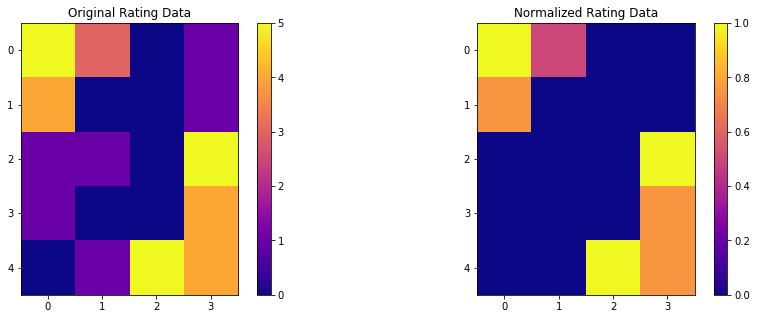

In [3]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(R, cmap='plasma',vmax=5,vmin=0)
plt.title('Original Rating Data')
plt.colorbar()
plt.subplot(122)
plt.imshow(R_normalized, cmap='plasma', vmax=1,vmin=0)  
plt.title('Normalized Rating Data')
plt.colorbar()
plt.show()

## Logistic Matrix Factorization

In [4]:
rank = 2
lmf = LMF(R_normalized_tc, mask_tc, rank, eta=0.05, nu=0.1, momentum=0.9, MAX_ITER=2000)
lmf.train()

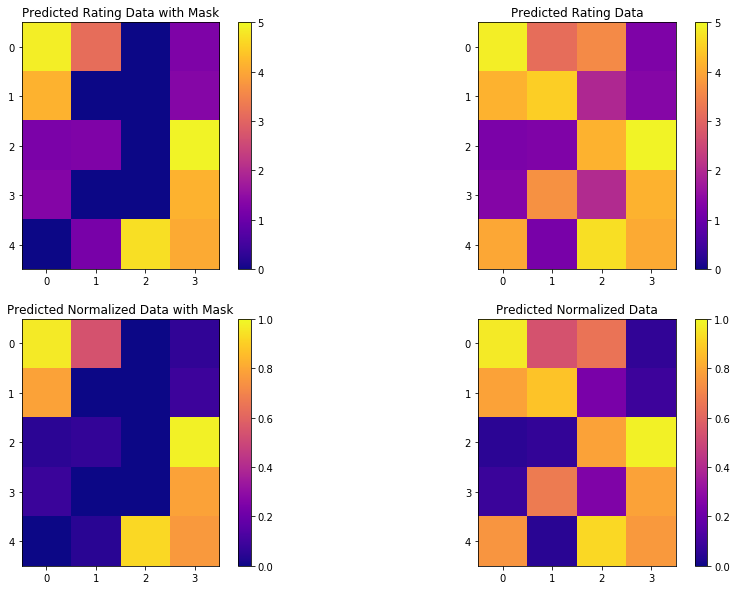

RMSE Error
0.8145537996190914


In [5]:
normalized_pred_tc = lmf.prediction
normalized_prediction = normalized_pred_tc.detach().numpy()
masked_normalized_prediction = mask * normalized_prediction
prediction = 4 * normalized_prediction + 1
masked_prediction = mask * prediction


plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(223)
plt.imshow(masked_normalized_prediction, cmap='plasma',vmax=1,vmin=0)  
plt.title('Predicted Normalized Data with Mask')
plt.colorbar()

plt.subplot(222)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.subplot(224)
plt.imshow(normalized_prediction, cmap='plasma',vmax=1,vmin=0)  
plt.title('Predicted Normalized Data')
plt.colorbar()
plt.show()

E = R - masked_prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)))

## Matrix Factorization

In [6]:
rank = 2
mf = MF(R_bias_tc, mask_tc, rank, eta=0.05, nu=0.1, momentum = 0.9, MAX_ITER=2000)
mf.train()

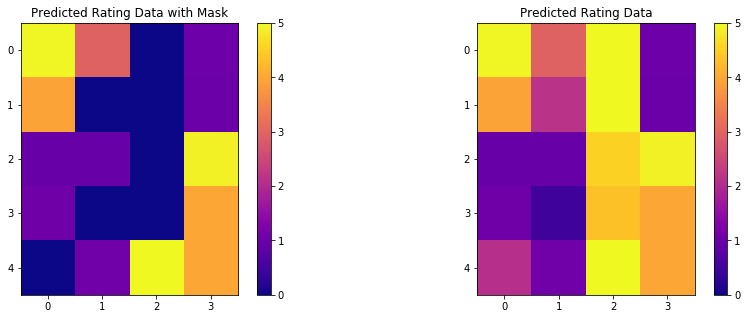

RMSE Error
0.16655725997573118


In [7]:
prediction_tc = mf.prediction
prediction = prediction_tc.detach().numpy() + bias
masked_prediction = mask * prediction

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.show()

E = R - masked_prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)))

## Probabilistic Matrix Factorization

In [8]:
R_samples = [
            (i, j, R[i, j])
            for i in range(M)
            for j in range(N)
            if R[i, j] > 0
        ]
R_samples = np.array(R_samples)

In [9]:
R_samples

array([[0, 0, 5],
       [0, 1, 3],
       [0, 3, 1],
       [1, 0, 4],
       [1, 3, 1],
       [2, 0, 1],
       [2, 1, 1],
       [2, 3, 5],
       [3, 0, 1],
       [3, 3, 4],
       [4, 1, 1],
       [4, 2, 5],
       [4, 3, 4]])

In [10]:
pmf = PMF()
pmf.set_params({"num_feat": 2, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 10, "num_batches": 100, "batch_size": 1000})
train, test = train_test_split(R_samples, test_size=0.2)
pmf.train(train, test)

Training RMSE: 0.067153, Test RMSE 0.786555
Training RMSE: 0.067043, Test RMSE 0.788965
Training RMSE: 0.067043, Test RMSE 0.788968
Training RMSE: 0.067043, Test RMSE 0.788968
Training RMSE: 0.067043, Test RMSE 0.788968
Training RMSE: 0.067043, Test RMSE 0.788968
Training RMSE: 0.067043, Test RMSE 0.788968
Training RMSE: 0.067043, Test RMSE 0.788968
Training RMSE: 0.067043, Test RMSE 0.788968
Training RMSE: 0.067043, Test RMSE 0.788968


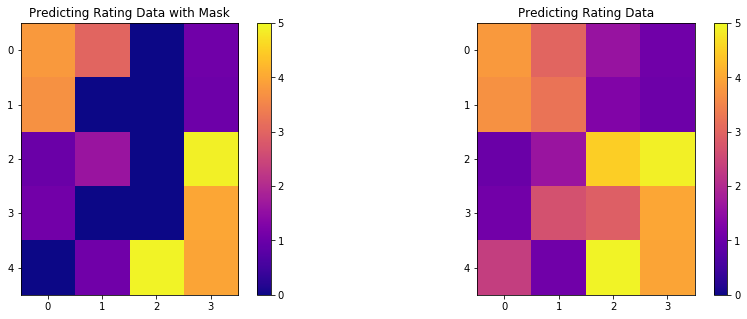

RMSE Error
1.3828815811600093


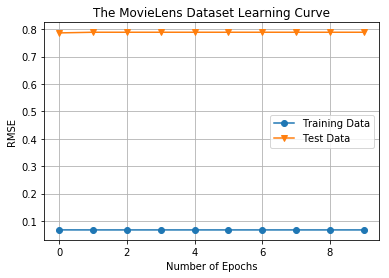

(0.10000000000000002, 1.0)
precision_acc,recall_acc:(0.10000000000000002, 1.0)


In [11]:
prediction = pmf.prediction
masked_prediction = mask * prediction

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicting Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicting Rating Data')
plt.colorbar()
plt.show()

E = R - masked_prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)))

plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
print("precision_acc,recall_acc:" + str(topK(prediction,test)))
print("precision_acc,recall_acc:" + str(pmf.topK(test)))

## Nonnegative Matrix Factorization

In [11]:
rank = 2
nmf = NMF(R, mask, rank, MAX_ITER=2000)
nmf.train()

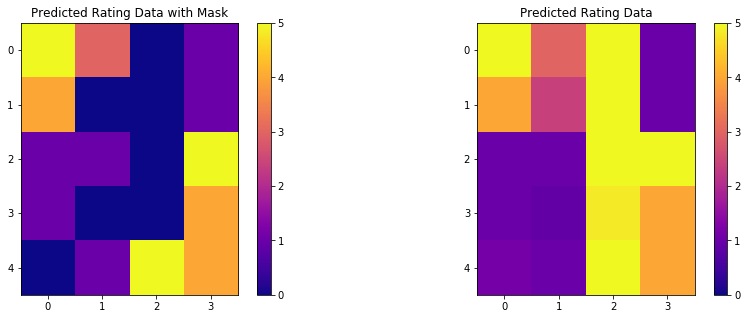

RMSE Error
8.881784197001252e-16


In [12]:
prediction = nmf.prediction
masked_prediction = mask * prediction

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.show()

E = R - masked_prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)))

## Alternating Least Squares

In [13]:
rank = 2
lambda_ = 0.1
als = ALS(R, mask, rank, lambda_, MAX_ITER=20)
als.train()

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
12th iteration is completed
13th iteration is completed
14th iteration is completed
15th iteration is completed
16th iteration is completed
17th iteration is completed
18th iteration is completed
19th iteration is completed


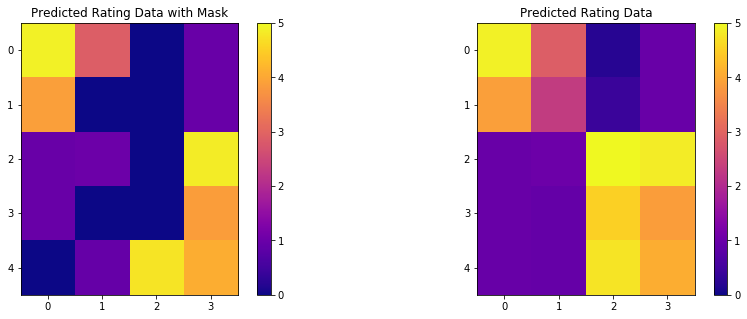

RMSE Error
0.36415064088737725


In [14]:
prediction = als.prediction
masked_prediction = mask * prediction

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(masked_prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data with Mask')
plt.colorbar()
plt.subplot(122)
plt.imshow(prediction, cmap='plasma',vmax=5,vmin=0)  
plt.title('Predicted Rating Data')
plt.colorbar()
plt.show()

E = R - masked_prediction
print ("RMSE Error")
print (np.sqrt(np.sum(E**2)))

In [18]:
R[1,:]

array([4, 0, 0, 1])

In [20]:
np.argsort(R[1,:])[-2:]

array([3, 0])